# Makemore from Scratch Part 5: Building a WaveNet

In this notebook, I'm following along with the YouTube video [Building makemore Part 5: Building a WaveNet](https://www.youtube.com/watch?v=t3YJ5hKiMQ0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=6), where [Andrej Karpathy](https://www.youtube.com/@AndrejKarpathy) continues walking through the development and optimization of a language model from scratch.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [5]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [6]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [7]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
    
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class Flatten:

  def __call__(self, x):
    self.out = x.view(x.shape[0], -1)
    return self.out
  
  def parameters(self):
    return []
      
# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:
  
  def __init__(self, n):
    self.n = n
    
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

In [38]:
torch.manual_seed(42); # seed rng for reproducibility

## Build the Model

In [9]:
# before using Embedding and Flatten layers
# n_embd = 10 # the dimensionality of the character embedding vectors
# n_hidden = 200 # the number of neurons in the hidden layer of the MLP
# C = torch.randn((vocab_size, n_embd))
# layers = [
#     Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#     Linear(n_hidden, vocab_size),
# ]

# using Embedding and Flatten layers
# n_embd = 10 # the dimensionality of the character embedding vectors
# n_hidden = 200 # the number of neurons in the hidden layer of the MLP
# layers = [
#     Embedding( vocab_size, n_embd ),
#     Flatten(),
#     Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#     Linear(n_hidden, vocab_size),
# ]

# original network
# n_embd = 10 # the dimensionality of the character embedding vectors
# n_hidden = 300 # the number of neurons in the hidden layer of the MLP
# model = Sequential([
#  Embedding(vocab_size, n_embd),
#  FlattenConsecutive(block_size), Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#  Linear(n_hidden, vocab_size),
# ])

# hierarchical network
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP
model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  # layers[-1].weight *= 0.1 # last layer make less confident
  model.layers[-1].weight *= 0.1 # last layer make less confident


# Before using Embedding layer
# parameters = [C] + [p for layer in layers for p in layer.parameters()]

# After using Embedding layer
#parameters = [p for layer in layers for p in layer.parameters()]

# After using Sequential
parameters = model.parameters()

print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

76579


In [21]:
#for layer in model.layers:
#    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

In [22]:
model.layers[3].running_mean.shape

torch.Size([1, 1, 128])

## Explore Wavenet Structure

In [ ]:
# Look at a batch of just 4 examples
ix = torch.randint( 0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape) # (4, block_size)
Xb

In [ ]:
# This is our embedding layer
# This layer plucks out the embedding vectors for each integer and organizes it in this structure
# [4, 8, 10]
# 4 is the number of examples (akin to the block size we might use)
# 8 is block_size (constant we defined above)
# 10 is n_embd, the dimensions for our word embeddings (constant defined above)
model.layers[0].out.shape

In [ ]:
# This is our flattened layer
# This layer stretches or concatenates all the 10-dimensional vectors into a single row
# [4, 80]
# 4 is the number of examples (akin to the block size we might use)
# 80 is block_size times n_embd
model.layers[1].out.shape

In [ ]:
# This is our Linear layer (hidden)
# This layer maps our flattened layer into our hidden layer
# [4, 300]
# 4 is the number of examples (akin to the block size we might use)
# 300 is n_hidden, the number of neurons in our hidden layer (constant defined above)
model.layers[2].out.shape

In [ ]:
# What's happening inside the Linear layer looks something like this:
#   multiplying weights and adding bias
(torch.randn(4, 80) @ torch.randn(80, 300) + torch.randn(300)).shape

In [ ]:
# We can interestingly and easily change the dimensionality of the 
#   input to the layer and the multiplication still works. Effectively,
#   the multiplication just happens on the last dimension of the input tensor
#   and the dimensions before it are left unchanged.

print( (torch.randn(4, 5, 80) @ torch.randn(80, 300) + torch.randn(300)).shape )
print( (torch.randn(4, 5, 5, 80) @ torch.randn(80, 300) + torch.randn(300)).shape )

In [ ]:
# We can use this to go from a flat structure to a grouped structure 
#   to achieve our wavenet architecture

# Before
# 1 2 3 4 5 6 7 8

# After
# (1 2) (3 4) (5 6) (7 8)


In [ ]:
# So what we want is something like this:
# 4 - examples
# 4 - groups (of 2)
# 20 - each group has 2 10-dimensional vectors
(torch.randn(4, 4, 20) @ torch.randn(20, 300) + torch.randn(300)).shape

In [29]:
# In Python, we can get even / odd indicies like this:
some_list = torch.tensor(list(range(10)))
print( "Full: ", some_list )
print( "Even: ", some_list[::2] )
print( " Odd: ", some_list[1::2] )

Full:  tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Even:  tensor([0, 2, 4, 6, 8])
 Odd:  tensor([1, 3, 5, 7, 9])


In [53]:
# So we have to update Flatten so it outputs a [4, 4, 20]
# The input (embedding layer) is [4, 8, 10]
e = torch.randn(4, 8, 10)
e_explicit = torch.cat( [ e[:, ::2, :], e[:, 1::2, :] ], dim=2)
e_view = e.view(4,4,20)
print( "Current flatten:", e.view(4, -1).shape)
print( "Explicit grouped flatten:", e_explicit.shape)

# But, the even simpler way to accomplish this is to do this:
print( "View grouped flatten:", e.view(4, 4, 20).shape )
print( "View == Explicit: ", (e_explicit == e.view(4,4,20)).all() )


original_first_two_rows = torch.cat( [ e[0][0], e[0][1] ])
new_first_row = e_view[0][0]
print( original_first_two_rows )
print( new_first_row )
print( "Original == New: ", (original_first_two_rows == new_first_row).all() )


Current flatten: torch.Size([4, 80])
Explicit grouped flatten: torch.Size([4, 4, 20])
View grouped flatten: torch.Size([4, 4, 20])
View == Explicit:  tensor(True)
tensor([-0.7496, -1.1346,  0.4310, -0.2231,  0.0405,  0.3553,  1.9383, -1.2549,
         0.4596,  1.5001,  0.3899,  0.4037, -0.4791, -0.5764, -2.3239, -0.2855,
        -0.5037,  0.5825, -2.6750,  0.1853])
tensor([-0.7496, -1.1346,  0.4310, -0.2231,  0.0405,  0.3553,  1.9383, -1.2549,
         0.4596,  1.5001,  0.3899,  0.4037, -0.4791, -0.5764, -2.3239, -0.2855,
        -0.5037,  0.5825, -2.6750,  0.1853])
Original == New:  tensor(True)


## Train the Model

In [16]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass - Not using an Embedding and Flattening layers
  # emb = C[Xb] # embed the characters into vectors
  # x = emb.view(emb.shape[0], -1) # concatenate the vectors
  # for layer in layers:
    # x = layer(x)
  # loss = F.cross_entropy(x, Yb) # loss function

  # forward pass - Using Embedding and Flattening layers
  # x = Xb
  # for layer in layers:
    # x = layer(x)
  # loss = F.cross_entropy(x, Yb) # loss function
    
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  # break

      0/ 200000: 2.0723
  10000/ 200000: 2.5134
  20000/ 200000: 2.1476
  30000/ 200000: 1.7836
  40000/ 200000: 2.2592
  50000/ 200000: 1.9331
  60000/ 200000: 1.6875
  70000/ 200000: 2.0395
  80000/ 200000: 1.7736
  90000/ 200000: 1.9569
 100000/ 200000: 1.7465
 110000/ 200000: 1.8126
 120000/ 200000: 1.7406
 130000/ 200000: 1.7466
 140000/ 200000: 1.8929
 150000/ 200000: 1.6865
 160000/ 200000: 1.6688
 170000/ 200000: 1.7853
 180000/ 200000: 1.8813
 190000/ 200000: 1.6659


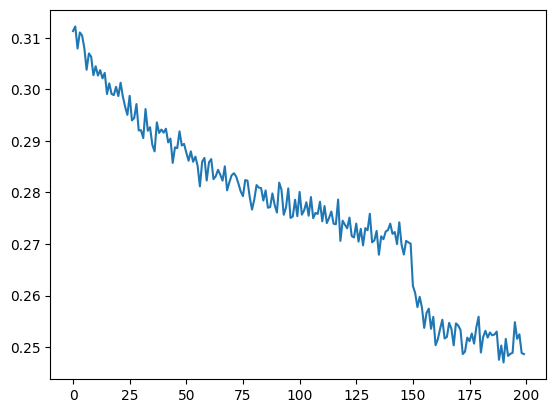

In [17]:
#plt.plot(lossi)
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))


In [18]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [19]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  # Before using Sequential
  # emb = C[Xb] # (N, block_size, nembd)
  # x = emb.view(emb.shape[0], -1) # concatenate into (N, block_size * n_embd)
  # for layer in layers:
    # x = layer(x)
  # loss = F.cross_entropy(x, y) # loss function

  # After using sequential
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7596352100372314
val 1.993744969367981


In [20]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

henrik.
anabela.
jalanie.
millena.
ender.
bellase.
ilyanna.
namyah.
anjelah.
mahanav.
aossa.
rhino.
joheleigh.
adliba.
ilenn.
libas.
aaleyah.
trysten.
alilene.
amourah.
